## Microtubule Dynamics ABM Julia notebook
This notebook is intended as a development and testing file , so i will change regulary.

nächstes meeting 05.10 10:45

### _TODO_ ::

    - Drei Abbildungen erstellen für klein 100, mittel300, groß1000 ,a 50 mal begrenzte randbedingungen,
    - seed funktion?!
    - Standartdabweichung (korridor) 
    - Rohdaten gut aufbewahren, sinnvolle beschriftungen  
    - Periodischen Randbedingugen mit in microtubuli modell implementieren ✓

  - Wachstumsgeswindigkeit (erstmal ohne Depolymerisation) ~ N.Agenten/Gridsize & P-polymerisiert


In [1]:
using Agents
using CairoMakie
using Distributions
using DataFrames
#import DrWatson: @dict

In [2]:
#= The agent class representing one tubulin dimer
    those can polymerize and also hydrolize from GTP to GDP
=#

@agent tubulin GridAgent{2} begin
    polym::Bool
    GDP::Bool
end

In [37]:
#= Main Function to initialize the model=#

function initialize(;Nstarts=1, numagents = 550, periodic=false,
        griddims = (100,100), 
        p_hyd= 0.001, 
        p_polym = 0.99,
        p_depolym_GTP= 0.005,
        p_depolym_GDP=0.01 )
   
    # Probability to hydrolize from GTP to GDP: 
    P_hyd = Binomial(1,p_hyd)
    # Probability to Polymerize/bind to the microtuble 
    P_polym = Binomial(1,p_polym)
    # Probability to depolimerize if not hydrolized (GTP - tubulin) = lower
    P_depolym_GTP = Binomial(1,1-p_depolym_GTP)
    # Probability to depolimerize if hydrolized (GDP - tubulin) = higher
    P_depolym_GDP = Binomial(1,1-p_depolym_GDP)
    
    
    properties = Dict(:griddims=> griddims,
                    :periodic=>periodic,
                    :numagents => numagents,
                    :Nstarts => Nstarts,
                    :p_hyd => p_hyd,
                    :p_polym => p_polym,
                    :p_depolym_GTP => p_depolym_GTP,
                    :p_depolym_GDP => p_depolym_GDP,
                    :P_hyd => P_hyd,
                    :P_polym=> P_polym,
                    :P_depolym_GTP=>  P_depolym_GTP,
                    :P_depolym_GDP=> P_depolym_GDP
                    )
    
    
    space = GridSpace(griddims, periodic= periodic, metric = :chebyshev)
    
    model = ABM(
        tubulin,space;
        scheduler = Schedulers.randomly,
        properties = properties
    )
    # populize Space
    id = 0
    # Startingpoints:
    for _ in 1:Nstarts
        id += 1
        agent =  tubulin(id,(50,50),true,true)
        if id == 1
            add_agent_pos!(agent,model) # add first staringpoint to center
        else
            add_agent_single!(agent,model) # add additional startingpoints to random positions 
        end
    end
    # unpolimerized (free) agents
    for _ in 1:numagents 
        id += 1
        agent =  tubulin(id,(1,1),false,false)
        add_agent_single!(agent,model) # add agents to random positions
    end
    return model
end

initialize (generic function with 1 method)

In [78]:
# peroidic agent step function
function agent_step!(agent,model)
    # bounce check für agenten (1|100 , y) | (x, 1|100) in eigene funktion aussiedeln
   if agent.id > model.Nstarts  
        # Logic for unpolymerized agents:
        if agent.polym == false      
             walk!(agent, rand, model, ifempty =true)#
        for id in nearby_ids(agent, model,1) # 
            if  model[id].polym == true
               if model[id].pos[1] == agent.pos[1] + 1 && model[id].pos[2] == agent.pos[2] + 1  || model[id].pos[1] == 1 && agent.pos[1] == model.griddims[1] && model[id].pos[2] == agent.pos[2]+1 || model[id].pos[1] == agent.pos[1] + 1 && model[id].pos[2] == 1 && agent.pos[2] == model.griddims[2]|| model[id].pos[1] == 1 && agent.pos[1] == model.griddims[1] && model[id].pos[2] == 1 && agent.pos[2] == model.griddims[2]
                    agent.polym = rand(model.P_polym,1)[1] 
                end
           end
       end
    if agent.polym
            if agent.GDP == false   # if not hydrolized
                agent.GDP = rand(model.P_hyd,1)[1] # hydrolize with P_hyd
            end
         if agent.pos[1]>1 && agent.pos[2]>1 && isempty(tuple(agent.pos[1]-1,agent.pos[2]-1),model) || agent.pos[1]==1 && agent.pos[2]>1 && isempty(tuple(model.griddims[1],agent.pos[2]-1),model)   || agent.pos[1]>1 && agent.pos[2]==1 && isempty(tuple(agent.pos[1]-1,model.griddims[2]),model)|| agent.pos[1]==1 && agent.pos[2]==1 && isempty(tuple(model.griddims[2],model.griddims[2]),model) || agent.pos[1] == model.griddims[1] && agent.pos[2]>1 && isempty(tuple(1, agent.pos[2]-1))|| agent.pos[1]>1 && agent.pos[2] == model.griddims[2] && isempty(tuple(agent.pos[2]-1,1 ))     
                if agent.GDP  # if hydrolized
                        agent.polym = rand(model.P_depolym_GDP,1)[1] # depolyimerize with P_depolym_GDP
                    else
                        agent.polym = rand(model.P_depolym_GTP,1)[1]
                    end
                end 
            end
        end
    end
end

agent_step! (generic function with 1 method)

In [34]:
# agent step func works with :chebyshev :non periodic
function agent_step!(agent,model)
    # Starting points have to stay the same
    if agent.id > model.Nstarts  
        # Logic for unpolymerized agents:
        if agent.polym == false            
            walk!(agent, rand, model, ifempty =true)# brownsche bewegung wenn nicht polymerisiert
            for id in nearby_ids(agent, model, [(1, 1:1), (2, 1:1)]) # check topright neighbour
                # Problem wenn periodisch metrik tuple arg Only possible with Chebyshev spaces.
              #for id in nearby_ids(agent, model,1)
                if model[id].polym # if polymerized
                    agent.polym = rand(model.P_polym,1)[1] # polimerize with P_polym
                end
            end
        end
        # Logic for polymierized agents:
        if agent.polym
            if agent.GDP == false   # if not hydrolized
                agent.GDP = rand(model.P_hyd,1)[1] # hydrolize with P_hyd
            end
            if isempty(tuple(agent.pos[1]-1,agent.pos[2]-1),model) # check if end of microtuble
             # Problem wenn periodisch metrik "attempt to access 100×100 Matrix{Vector{Int64}} at index [13, 0]""

                if agent.GDP  # if hydrolized
                        agent.polym = rand(model.P_depolym_GDP,1)[1] # depolyimerize with P_depolym_GDP
                    else
                        agent.polym = rand(model.P_depolym_GTP,1)[1] # depolymerize with P_depolym_GDP     
                end
            end
        end
    end 
end

agent_step! (generic function with 1 method)

In [5]:
# model-Step func:
function model_step!(model)
    # TODO: calculate mean squared displacement MSD for every tick
    # calculate mean microtuble length 

end

model_step! (generic function with 1 method)

In [79]:
# initialization
model = initialize(
    periodic= true,
    Nstarts=3,
    numagents = 800,
    p_polym=0.99,
    p_hyd= 0.15,
    p_depolym_GTP=0.09,
    p_depolym_GDP=0.09)


AgentBasedModel with 803 agents of type tubulin
 space: GridSpace with size (100, 100), metric=chebyshev, periodic=true
 scheduler: randomly
 properties: Dict{Symbol, Any}(:griddims => (100, 100), :P_hyd => Binomial{Float64}(n=1, p=0.15), :p_depolym_GDP => 0.09, :Nstarts => 3, :P_depolym_GTP => Binomial{Float64}(n=1, p=0.91), :periodic => true, :P_depolym_GDP => Binomial{Float64}(n=1, p=0.91), :p_polym => 0.99, :p_hyd => 0.15, :p_depolym_GTP => 0.09…)

In [80]:
#Video out:
using InteractiveDynamics
using GLMakie
# coloring

groupcolor(a) = a.polym == true ? :red : :blue
groupmarker(a) = a.GDP == true ? :circle : '○'

#GLMakie.activate!()

abm_video(
    "Microtubule_continuus.mp4", model, agent_step!,model_step!;
    ac = groupcolor, am = groupmarker,
    framerate = 10, frames = 2000,
    title = "Microtubule Simulation:"
)


In [ ]:
### Data collection

adata = [:pos, :polym, :GDP]

model = initialize(griddims =(50,50),
    Nstarts=0,
    numagents = 40,
    p_polym=0.99,
    p_hyd= 0.0,
    p_depolym_GTP=0.0,
    p_depolym_GDP=0.0)

data, _ = run!(model,agent_step!, model_step!,100;adata)




In [86]:
# MSD function
function MSD(data)   
    n_ids= maximum(data.id)
    n_steps=maximum(data.step)+1
    r=1:n_ids:n_steps*n_ids+n_ids
    poses=hcat(collect.(data.pos)...)
    x_0=poses[1,unique(data.id)]
    y_0=poses[2,unique(data.id)]
    MSD = zeros(n_steps) #array länge data.step init zeros()
        for i in 1:n_steps
            MSD[i]=mean(sqrt.((poses[1,r[i]:r[i+1]-1].-x_0).^2 + (poses[2,r[i]:r[i+1]-1].-y_0).^2))
        end
    return MSD
end

MSD (generic function with 1 method)

In [87]:
## Ensemble run
models = [initialize(; Nstarts=0,
        numagents=200,
        griddims=(x,x), 
        p_hyd=0,
        p_polym=0,
        p_depolym_GTP=0,
        p_depolym_GDP=0) for x in repeat([100, 300, 1000], 2)
];

adata = [:pos]

adf, = ensemblerun!(models, agent_step!, model_step!, 500; adata)


(601200×4 DataFrame
    Row │ step   id     pos         ensemble 
        │ Int64  Int64  Tuple…      Int64    
────────┼────────────────────────────────────
      1 │     0      1  (47, 88)           1
      2 │     0      2  (53, 4)            1
      3 │     0      3  (85, 51)           1
      4 │     0      4  (3, 60)            1
      5 │     0      5  (34, 95)           1
      6 │     0      6  (89, 39)           1
      7 │     0      7  (3, 87)            1
      8 │     0      8  (36, 81)           1
      9 │     0      9  (63, 72)           1
     10 │     0     10  (59, 35)           1
     11 │     0     11  (37, 55)           1
   ⋮    │   ⋮      ⋮        ⋮          ⋮
 601191 │   500    191  (461, 160)         6
 601192 │   500    192  (193, 651)         6
 601193 │   500    193  (339, 342)         6
 601194 │   500    194  (452, 112)         6
 601195 │   500    195  (146, 100)         6
 601196 │   500    196  (480, 875)         6
 601197 │   500    197  (567, 199)  

In [91]:
using CSV
CSV.write("ensemble_100_300_1k_a50runs.csv", adf)

"ensemble_100_300_1k_a50runs.csv"

In [88]:
## MSD for multiple ensembles

MSDS = DataFrame(Step= levels(adf.step))
for i in levels(adf.ensemble)
    name = Symbol("ens_$i")
    MSDS[!,name] = MSD(adf[(adf.ensemble .== i ),:])
end

CSV.write("MSDS_ensemble_100_300_1k_a50runs.csv", MSDS)

,Step,ens_1,ens_2,ens_3,ens_4,ens_5,ens_6
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1.02412,1.08433,1.09054,1.02518,1.0564,1.10589
3,2,1.55179,1.45368,1.43977,1.40849,1.44641,1.36171
4,3,1.89645,1.74875,1.81051,1.69996,1.7041,1.6782
5,4,2.12173,2.01814,2.11478,2.04398,2.05286,2.00551
6,5,2.33743,2.19859,2.33226,2.34231,2.34356,2.31726
7,6,2.51145,2.41612,2.60058,2.45983,2.64558,2.52931
8,7,2.68019,2.74038,2.77746,2.74142,2.9235,2.6671
9,8,2.92758,2.9116,2.89853,2.94425,3.09318,2.8511


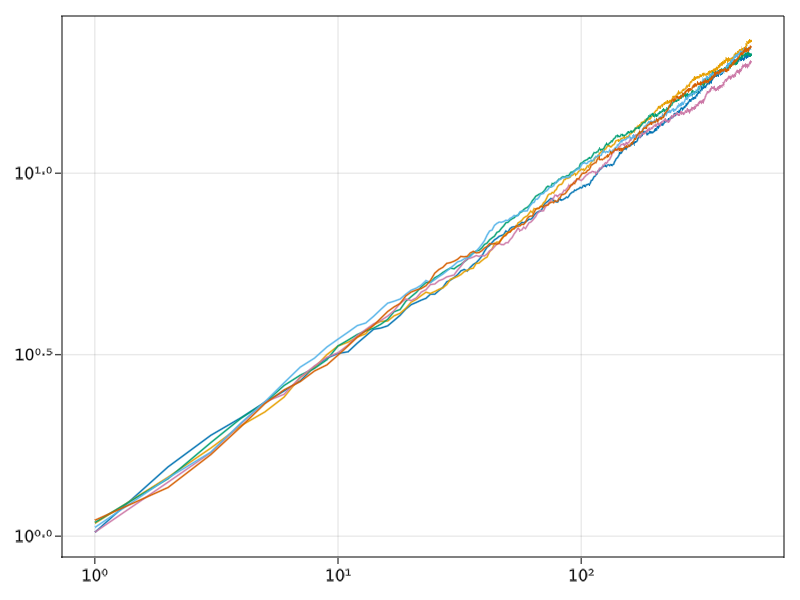

In [89]:
# MSD plots
MSDS = MSDS[setdiff(1:end, 1), :]#delete 0 timestep before plotting since log(0) not defined.
f = Figure()
Axis(f[1, 1],yscale=log10,xscale=log10)
#Axis(f[1,1])
lines!(MSDS.ens_1)
lines!(MSDS.ens_2)
lines!(MSDS.ens_3)
lines!(MSDS.ens_4)
lines!(MSDS.ens_5)
lines!(MSDS.ens_6)

f


In [65]:
# Interactive exploration:
using Statistics
using CairoMakie
using InteractiveDynamics
using GLMakie
# parameter Range for sliders
model = initialize(; numagents = 600,Nstarts=4)

parange = Dict(
    :Nstarts => 1:30,
    :numagents => 100:1000,
    :p_hyd =>0.0:0.01:1.0, 
    :p_polym => 0.0:0.01:1.0, 
    :p_depolym_GTP =>0.0:0.01:1.0,
    :p_depolym_GDP => 0.0:0.01:1.0,)


groupcolor(a) = a.polym == true ? :red : :blue
groupmarker(a) = a.GDP == true ? :circle : '○'


adata = [(:polym,sum), (:GDP,sum)]
alabels = ["Polimerized", "Hydrolized"]



figure, adf, mdf = abm_data_exploration( 
    model, agent_step!, model_step!, parange;
    ac = groupcolor, am = groupmarker, as = 10,
    adata, alabels
)



(Scene (1600px, 800px):
  94 Plots:
    ├ Combined{Makie.poly, Tuple{Vector{Vector{Point{2, Float32}}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{Vector{Tuple{AbstractString, Point{2, Float32}}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ LineSegments{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{Vector{Tuple{AbstractString, Point{2, Float32}}}}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ Lines{Tuple{Vector{Point{2, Float32}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ Scatter{Tuple{Vec